In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd

In [44]:
# {1:crack,2:scratch, 3:tire flat, 4:dent,5:glass shatter,6:lamp broken}
class_names = ['crack', 'scratch', 'tire flat', 'dent', 'glass shatter', 'lamp broken']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)
print(class_names_label)
print(nb_classes)

{'crack': 0, 'scratch': 1, 'tire flat': 2, 'dent': 3, 'glass shatter': 4, 'lamp broken': 5}
6


In [19]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 06C6-74B6

 Directory of C:\Users\madhav.kumar\Documents\AI-ML-DS\Image Classification

18-12-2023  02.13 PM    <DIR>          .
18-12-2023  02.13 PM    <DIR>          ..
14-12-2023  12.13 PM    <DIR>          .ipynb_checkpoints
04-12-2023  12.54 PM       363,152,213 archive (2).zip
05-12-2023  11.53 AM                72 Exploratory Data Analysis(EDA).ipynb
05-12-2023  11.52 AM           389,834 image-classification-using-cnn-94-accuracy.ipynb
18-12-2023  02.13 PM         1,643,080 image_classifficatin_car_insurance.ipynb
18-12-2023  01.57 PM         3,624,785 image_classification_intel_data.ipynb
13-12-2023  03.51 PM    <DIR>          intel_data
22-11-2023  12.11 PM           134,325 kbs.ipynb
13-12-2023  03.52 PM    <DIR>          Ripik_AI
03-12-2023  04.19 PM            35,616 sample_submission-3.csv
               7 File(s)    368,979,925 bytes
               5 Dir(s)  311,364,132,864 bytes free


In [45]:
# Function to get label by filename
def get_label_by_filename(df, filename):
    try:
        label = df[df['filename'] == filename]['label'].values[0]
        return label
    except IndexError:
        return f"No label found for filename: {filename}"


In [66]:
# making data frame from csv file
data = pd.read_csv("Ripik_AI/train/train.csv")
data.head()

,image_id,filename,label
0,1,1.jpg,2
1,2,2.jpg,4
2,3,3.jpg,2
3,4,4.jpg,3
4,5,5.jpg,5


In [67]:
data["label"] = data["label"] - 1
data.head()

,image_id,filename,label
0,1,1.jpg,1
1,2,2.jpg,3
2,3,3.jpg,1
3,4,4.jpg,2
4,5,5.jpg,4


In [68]:
def load_data():
    datasets = ['Ripik_AI/train/images']
    output = []
    # count = 0
    
    for dataset in datasets:
            
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
    
        for file in tqdm(os.listdir(dataset)):
            
            # Get the path name of the image
            img_path = os.path.join(dataset, file)

             # Open and resize the img
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE) 

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(get_label_by_filename(data, file))
            
            # print(file)
            # count += 1
            # print(get_label_by_filename(data, file))
            # if count == 5:
            #     count=0
            #     break
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))
    
    return output    

In [69]:
(train_images, train_labels) = load_data()[0]

Loading Ripik_AI/train/images


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7200/7200 [02:21<00:00, 50.73it/s]


In [70]:
print(train_labels)

[1 4 5 ... 3 3 1]


In [71]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [72]:
n_train = train_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 7200
Each image is of size: (150, 150)


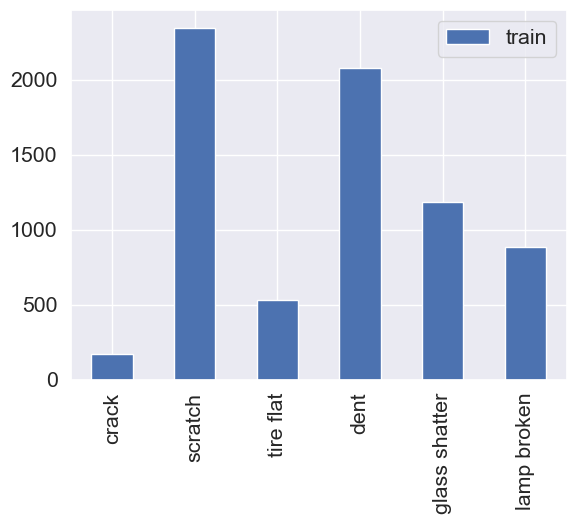

In [73]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
pd.DataFrame({'train': train_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

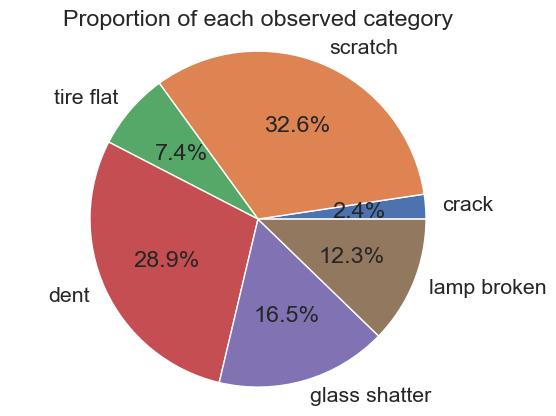

In [74]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [75]:
train_images = train_images / 255.0 

In [84]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

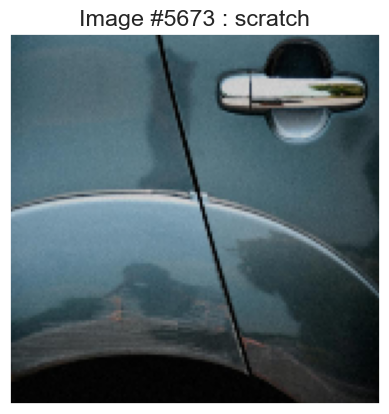

In [85]:
display_random_image(class_names, train_images, train_labels)

In [86]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

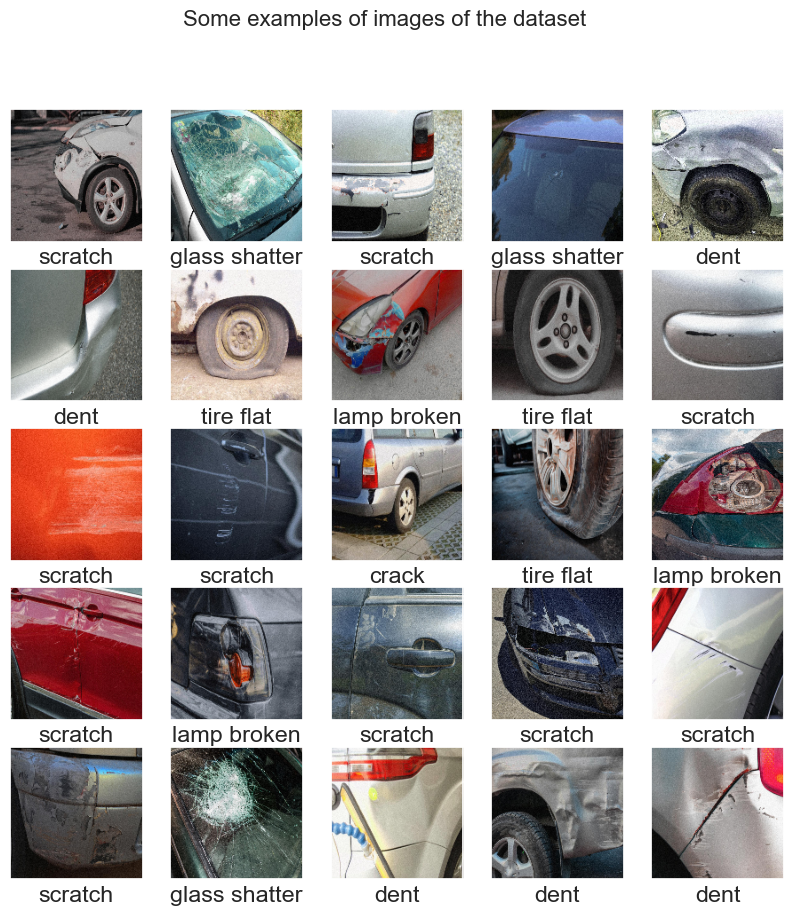

In [87]:
display_examples(class_names, train_images, train_labels)

In [88]:
model = tf.keras.Sequential([
    # First convolutional layer with 32 filters, each of size (3, 3), and ReLU activation function
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    # Max pooling layer with a pool size of (2, 2)
    tf.keras.layers.MaxPooling2D(2,2),
    # Second convolutional layer with 32 filters, each of size (3, 3), and ReLU activation function
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    # Max pooling layer with a pool size of (2, 2)
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten layer to convert the 2D output to a 1D vector
    tf.keras.layers.Flatten(),
     # Fully connected dense layer with 128 neurons and ReLU activation function
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
     # Output layer with 6 neurons (classification problem) and softmax activation function
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [89]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [90]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
45/45 [==============================] - 18s 386ms/step - loss: 2.0972 - accuracy: 0.3155 - val_loss: 1.5743 - val_accuracy: 0.3181
Epoch 2/20
45/45 [==============================] - 18s 395ms/step - loss: 1.4105 - accuracy: 0.3991 - val_loss: 1.4202 - val_accuracy: 0.3806
Epoch 3/20
45/45 [==============================] - 18s 390ms/step - loss: 1.2429 - accuracy: 0.5061 - val_loss: 1.2540 - val_accuracy: 0.4965
Epoch 4/20
45/45 [==============================] - 18s 395ms/step - loss: 1.0289 - accuracy: 0.5953 - val_loss: 1.1168 - val_accuracy: 0.5667
Epoch 5/20
45/45 [==============================] - 19s 425ms/step - loss: 0.8283 - accuracy: 0.6929 - val_loss: 1.0854 - val_accuracy: 0.5861
Epoch 6/20
45/45 [==============================] - 22s 483ms/step - loss: 0.6169 - accuracy: 0.7859 - val_loss: 0.8882 - val_accuracy: 0.6743
Epoch 7/20
45/45 [==============================] - 21s 456ms/step - loss: 0.4365 - accuracy: 0.8561 - val_loss: 0.8462 - val_accuracy: 0.7229

In [91]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

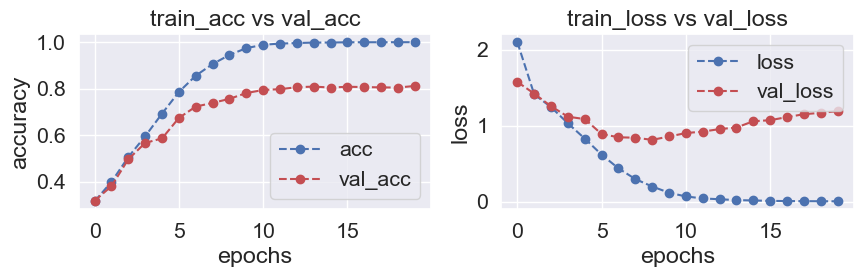

In [92]:
plot_accuracy_loss(history)

In [93]:
test_loss = model.evaluate(test_images, test_labels)

NameError: name 'test_images' is not defined

225/225 [==============================] - 6s 27ms/step


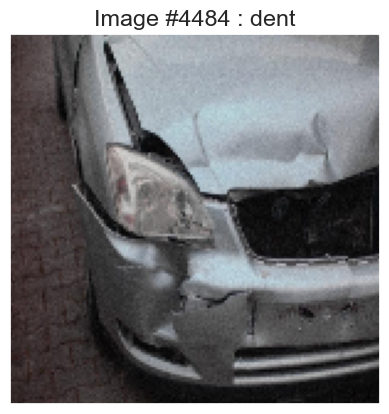

In [96]:
predictions = model.predict(train_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, train_images, pred_labels)